In [1]:
import numpy as np  # numpy is for numerics, arrays, sin/cos etc.
import cmocean      # nice colormaps for climate science
import matplotlib.pyplot as plt # plotting tool
import xarray as xr # read/write netcdf and simple statistics
import cartopy.crs as ccrs # map plots

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit=32e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:51998 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 238.42 GiB


In [5]:
# Runs

In [26]:
nemo_dir = '/Users/jkjellsson/Downloads/gyre_data/'

names = ['GYRE_R2'] #,'GYRE_R4','GYRE_R10']
exps  = ['GYRE_R2_GM'] #,'GYRE_R4','GYRE_R10']
res   = [2] #, 4, 10, 20] 

tfiles = []
ffiles = []

for exp in exps:
    gyre = '%s/%s/GYRE_1y' % (nemo_dir,exp)
    print(gyre)
    ds_t = xr.open_mfdataset('%s*_grid_T.nc' % (gyre,), combine='by_coords')
    tfiles.append(ds_t)
    # these are the F-files with vorticity. skip for now. 
    #ffiles.append(ds_f)
    #ds_f = xr.open_mfdataset('%s*_grid_F.nc' % (gyre,), combine='by_coords')

/Users/jkjellsson/Downloads/gyre_data//GYRE_R2_GM/GYRE_1y


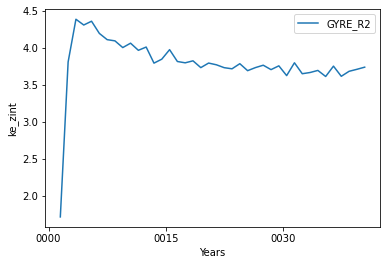

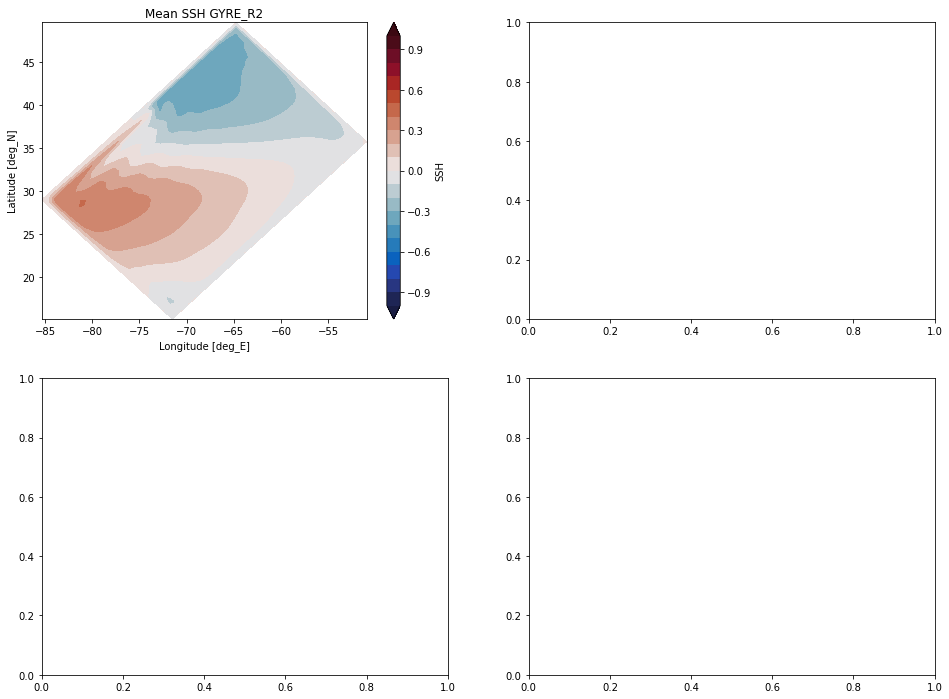

In [10]:
# Plot global mean KE
fig1, ax1 = plt.subplots(1,1)
fig2, axs2 = plt.subplots(2,2,figsize=(16,12))
ax2 = axs2.flat

for i in range(0,len(tfiles)):
    
    ds_t = tfiles[i]
    # comment out f-files for now
    #ds_f = ffiles[i]
    name  = names[i]
    
    ds_t['ke_zint'].mean('x').mean('y').plot(ax=ax1,label=name)
    
    # Mean SSH
    ssh_lev = np.linspace(-1,1,21)
    cmap = cmocean.cm.balance
    x = ds_t['nav_lon'].values.flatten()
    y = ds_t['nav_lat'].values.flatten()
    z = ds_t['ssh'].sel(time_counter = slice('0030-01-01T00:00:00','0040-01-01T00:00:00')).mean('time_counter')[:,:].values.flatten()
    cf = ax2[i].tricontourf( x, y, z,  
                             levels = ssh_lev, cmap=cmap, extend='both' )
    cb = plt.colorbar(cf, ax=ax2[i])
    cb.set_label('SSH')
    ax2[i].set_title('Mean SSH %s' % (name,))
    ax2[i].set_xlabel('Longitude [deg_E]')
    ax2[i].set_ylabel('Latitude [deg_N]')
    
    # Snapshot of last time step rel vor
    #rvo_lev = np.linspace(-2,2,21) * 1e-5
    #cmap = cmocean.cm.curl
    #fig_rvo, ax_rvo = plt.subplots(1,1)
    #cf = ax_rvo.tricontourf( ds_f['nav_lon'].values.flatten(), 
    #                         ds_f['nav_lat'].values.flatten(), 
    #                         ds_f['relvor'][:,0,:,:].values.flatten(), 
    #                         levels = rvo_lev, cmap=cmap, extend='both' )
    #cb = plt.colorbar(cf, ax=ax_rvo)
    #cb.set_label('Rel. vort.')
    #ax_rvo.set_xlabel('Longitude [deg_E]')
    #ax_rvo.set_ylabel('Latitude [deg_N]')
    #fig_rvo.savefig('%s_rvo_last_step.png' % (name,),format='png')
    
ax1.set_xlabel('Years')
ax1.legend()

fig1.savefig('KE_timeseries.png',format='png')
fig2.savefig('SSH_mean.png',format='png')

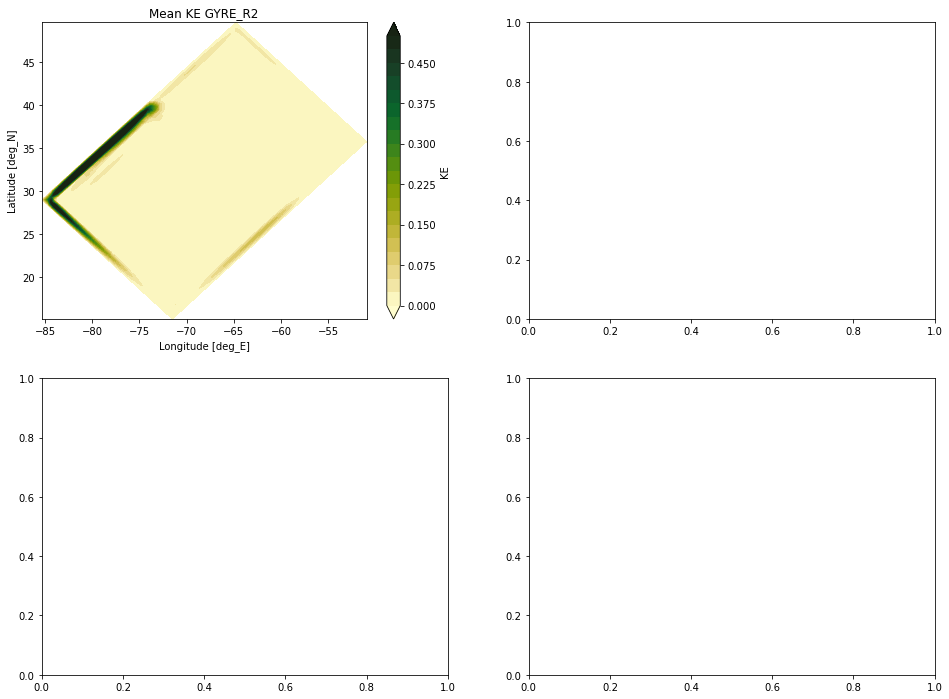

In [11]:
# Plot global mean KE
fig1, axs1 = plt.subplots(2,2,figsize=(16,12))
ax1 = axs1.flat

for i in range(0,len(tfiles)):
    
    ds_t = tfiles[i]
    name  = names[i]
    
    # Mean KE
    ke_lev = np.linspace(0,0.5,21)
    cmap = cmocean.cm.speed
    x = ds_t['nav_lon'].values.flatten()
    y = ds_t['nav_lat'].values.flatten()
    z = ds_t['ke'].sel(time_counter = slice('0030-01-01T00:00:00','0040-01-01T00:00:00')).mean('time_counter')[0,:,:].values.flatten()
    cf = ax1[i].tricontourf( x, y, z,  
                             levels = ke_lev, cmap=cmap, extend='both' )
    cb = plt.colorbar(cf, ax=ax1[i])
    cb.set_label('KE')
    ax1[i].set_title('Mean KE %s' % (name,))
    ax1[i].set_xlabel('Longitude [deg_E]')
    ax1[i].set_ylabel('Latitude [deg_N]')
    
fig1.savefig('KE_mean.png',format='png')

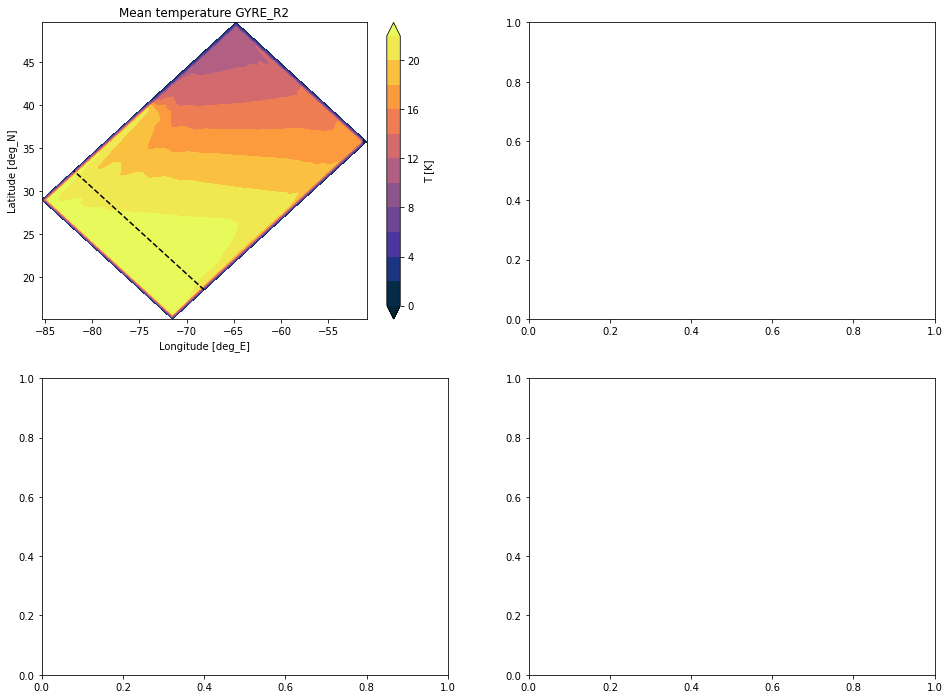

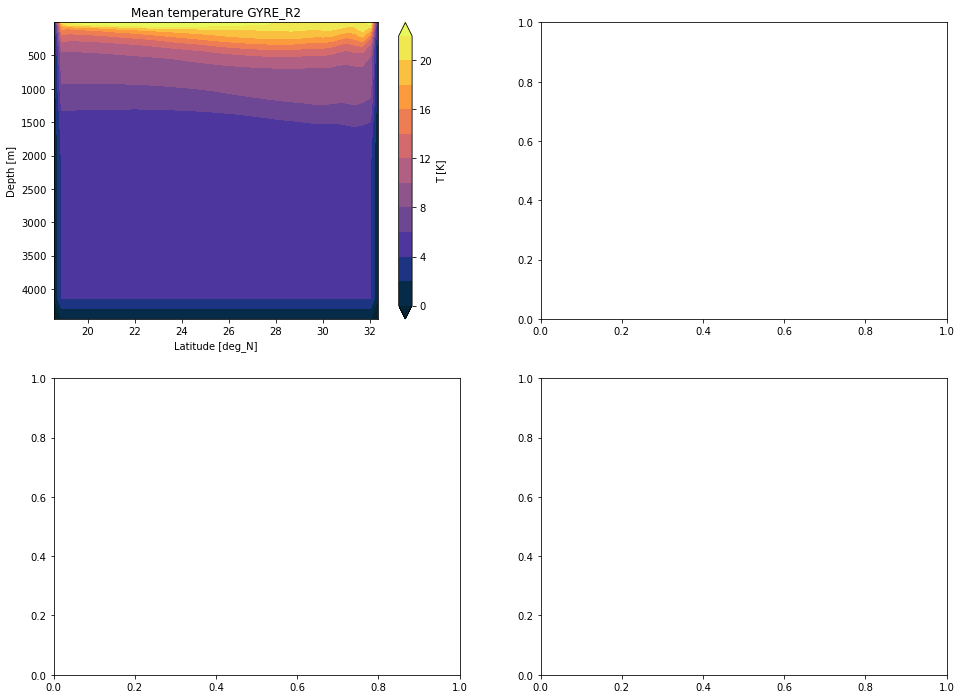

In [27]:
# Plot temperature cross section
fig1, axs1 = plt.subplots(2,2,figsize=(16,12))
ax1 = axs1.flat

fig2, axs2 = plt.subplots(2,2,figsize=(16,12))
ax2 = axs2.flat

for i in range(0,len(tfiles)):
    
    ds_t = tfiles[i] # select the data set from the list
    name  = names[i]
    
    # set a colormap for temperature
    # see https://matplotlib.org/cmocean/
    tlev = np.linspace(0,22,12)
    cmap = cmocean.cm.thermal
    
    # flatten lon,lat to 1d arrays
    x = ds_t['nav_lon'].values.flatten()
    y = ds_t['nav_lat'].values.flatten()
    # time mean of temperature
    t = ds_t['toce'].sel(time_counter = slice('0030-01-01T00:00:00','0040-01-01T00:00:00')).mean('time_counter')
    
    # i-index of cross section
    # we choose a number (e.g. 5) and multiply by resolution so that cross section is at same lon/lat for all runs
    x_cross = 5 * res[i]
    # select temperature at x_cross
    t_cross = t.isel(x=x_cross)
    
    # plot t at surface (and and flatten to 1D array)
    cf = ax1[i].tricontourf( x, y, t[0,:,:].values.flatten(), levels=tlev, cmap=cmap, extend='both' )
    # draw line at lon,lat of cross section 
    ax1[i].plot(ds_t['nav_lon'][:,x_cross],ds_t['nav_lat'][:,x_cross],'--k')
    # now draw colorbar, set labels etc
    cb = plt.colorbar(cf, ax=ax1[i])
    cb.set_label('T [K]')
    ax1[i].set_title('Mean temperature %s' % (name,))
    ax1[i].set_xlabel('Longitude [deg_E]')
    ax1[i].set_ylabel('Latitude [deg_N]')
    
    # plot temperature cross section
    x = ds_t['nav_lat'][:,x_cross] # we use latitude as x coord
    y = ds_t['deptht'] # we use depth as y coord
    cf = ax2[i].contourf( x, y, t_cross, cmap=cmap, levels=tlev, extend='both' )
    ax2[i].invert_yaxis() # invert y axis so it starts at ocean bottom
    cb = plt.colorbar(cf, ax=ax2[i])
    cb.set_label('T [K]')
    ax2[i].set_title('Mean temperature %s' % (name,))
    ax2[i].set_xlabel('Latitude [deg_N]')
    ax2[i].set_ylabel('Depth [m]')

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


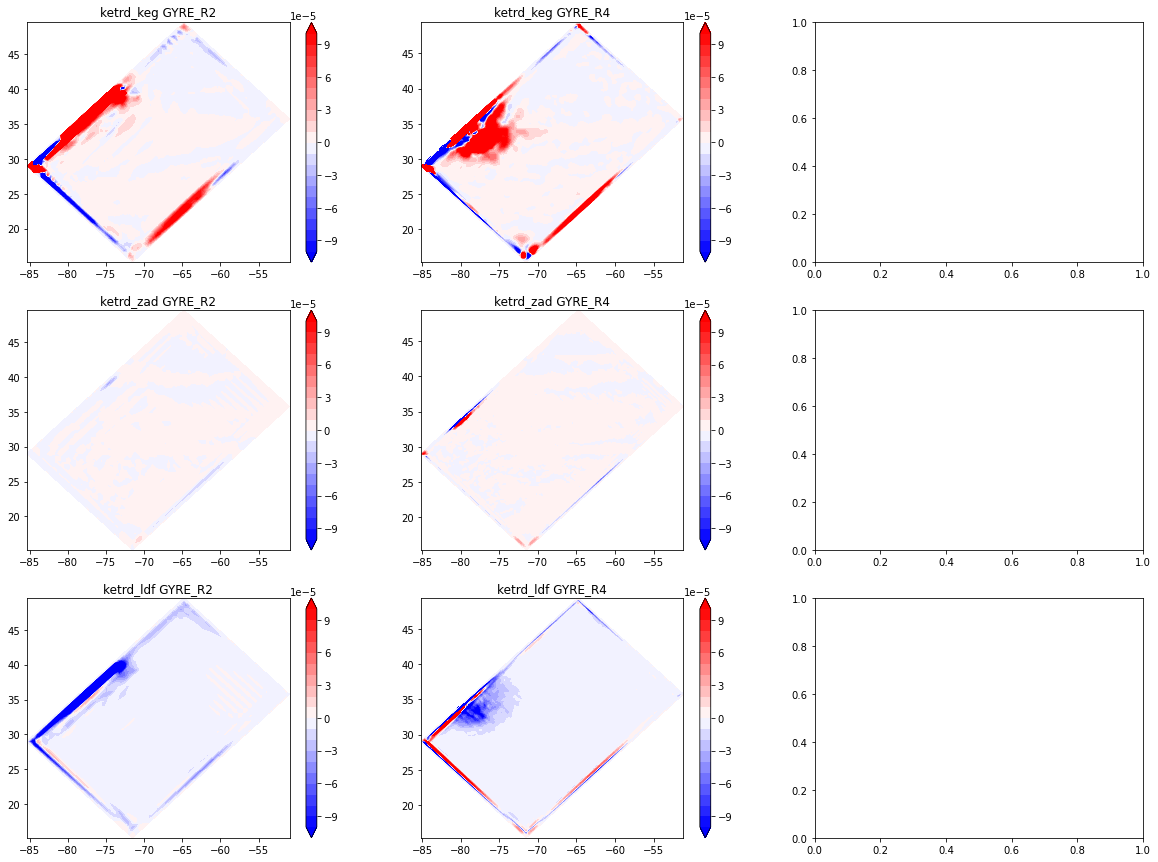

In [46]:
# Plot global mean KE
fig1, ax1 = plt.subplots(3,3,figsize=(20,15))

for i in range(0,2):#len(tfiles)):
    
    ds_t = tfiles[i]
    name  = names[i]
    
    ketrd_lev = np.linspace(-1,1,21) * 1e-4
    x = ds_t['nav_lon'].values.flatten()
    y = ds_t['nav_lat'].values.flatten()
    vars = ['ketrd_keg','ketrd_zad','ketrd_ldf']
    for j in range(0,len(vars)):
        var = vars[j]
        z = ds_t[var].sel(time_counter = slice('0030-01-01T00:00:00','0040-01-01T00:00:00')).mean('time_counter')[0,:,:].values.flatten()
        #z = ds_t[var][-1,0,:,:].values.flatten()
        print(z)
        cf = ax1[j,i].tricontourf( x,y,z,
                                   cmap=plt.cm.bwr, extend='both', levels=ketrd_lev )
        cb = plt.colorbar(cf, ax=ax1[j,i])
        ax1[j,i].set_title('%s %s' % (var,name))
    
#fig1.savefig('KE_timeseries.png',format='png')